In [30]:
import pandas as pd
import plotly.graph_objs as go
import plotly.express as px
import plotly.io as pio
import matplotlib.pyplot as plt
import seaborn as sns
pio.templates.default = "plotly_white"

data = pd.read_csv('monthly_gdp.csv')
print(data.head())

  Time Period  GDP Growth
0    /01/2020         0.3
1    /02/2020        -0.5
2    /03/2020        -7.0
3    /04/2020       -20.9
4    /05/2020         3.2


In [31]:
data.info()
data.describe

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Time Period  36 non-null     object 
 1   GDP Growth   36 non-null     float64
dtypes: float64(1), object(1)
memory usage: 704.0+ bytes


<bound method NDFrame.describe of    Time Period  GDP Growth
0     /01/2020         0.3
1     /02/2020        -0.5
2     /03/2020        -7.0
3     /04/2020       -20.9
4     /05/2020         3.2
5     /06/2020         9.0
6     /07/2020         7.4
7     /08/2020         2.0
8     /09/2020         1.1
9     /10/2020         0.6
10    /11/2020        -1.8
11    /12/2020         1.8
12    /01/2021        -2.9
13    /02/2021         0.7
14    /03/2021         2.3
15    /04/2021         3.1
16    /05/2021         1.3
17    /06/2021         1.0
18    /07/2021        -0.2
19    /08/2021         0.9
20    /09/2021         0.6
21    /10/2021         0.1
22    /11/2021         1.0
23    /12/2021         0.1
24    /01/2022         0.1
25    /02/2022         0.0
26    /03/2022         0.1
27    /04/2022        -0.2
28    /05/2022         0.7
29    /06/2022        -0.9
30    /07/2022         0.3
31    /08/2022         0.0
32    /09/2022        -0.8
33    /10/2022         0.5
34    /11/2022       

In [48]:
# Compute descriptive statistics
descriptive_stats = quarterly_data['GDP Growth'].describe()
print(descriptive_stats)


count    12.000000
mean      0.072222
std       1.652475
min      -2.900000
25%      -0.141667
50%       0.050000
75%       0.408333
max       3.500000
Name: GDP Growth, dtype: float64


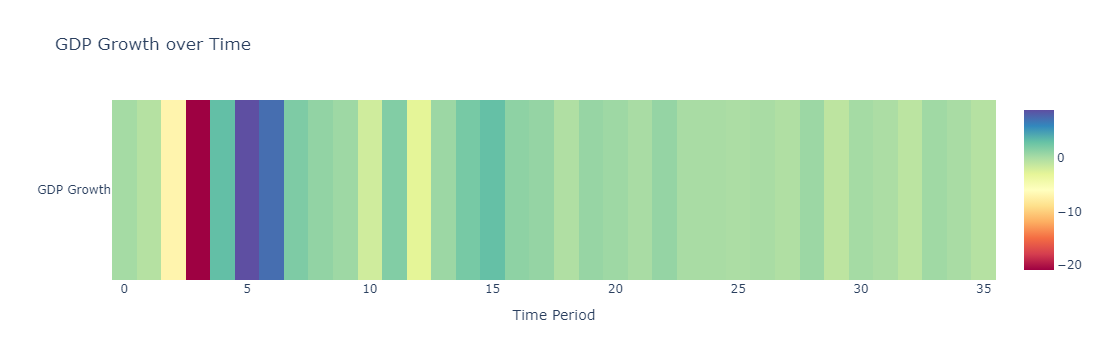

In [32]:
fig = go.Figure(data=go.Heatmap(
                   z=[data['GDP Growth']],
                   x=data.index,
                   y=['GDP Growth'],
                   colorscale='Spectral'))

fig.update_layout(title='GDP Growth over Time',
                  xaxis_title='Time Period',
                  yaxis_title='')

fig.show()

In [33]:
data['Time Period'] = pd.to_datetime(data['Time Period'], format='/%m/%Y')
data.set_index('Time Period', inplace=True)
quarterly_data = data.resample('Q').mean()
print(quarterly_data.head())

             GDP Growth
Time Period            
2020-03-31    -2.400000
2020-06-30    -2.900000
2020-09-30     3.500000
2020-12-31     0.200000
2021-03-31     0.033333


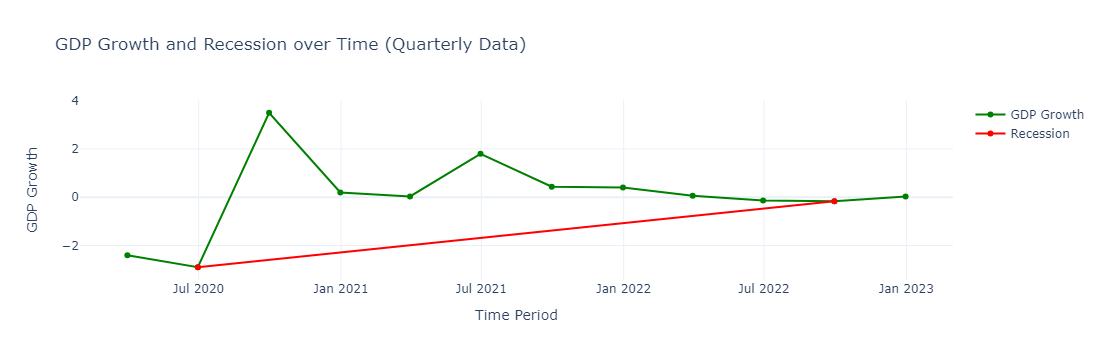

In [34]:
quarterly_data['Recession'] = ((quarterly_data['GDP Growth'] < 0) & (quarterly_data['GDP Growth'].shift(1) < 0))
quarterly_data['Recession'].fillna(False, inplace=True)
fig = go.Figure()
fig.add_trace(go.Scatter(x=quarterly_data.index, 
                         y=quarterly_data['GDP Growth'], 
                         name='GDP Growth', 
                         line=dict(color='green', width=2)))
fig.add_trace(go.Scatter(x=quarterly_data[quarterly_data['Recession']].index, 
                         y=quarterly_data[quarterly_data['Recession']]['GDP Growth'], 
                         name='Recession', line=dict(color='red', width=2)))

fig.update_layout(title='GDP Growth and Recession over Time (Quarterly Data)',
                  xaxis_title='Time Period',
                  yaxis_title='GDP Growth')

fig.show()

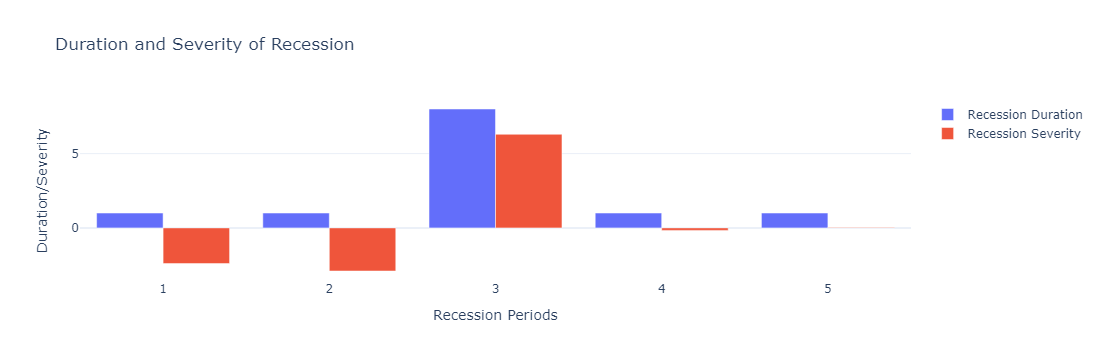

In [35]:
quarterly_data['Recession Start'] = quarterly_data['Recession'].ne(quarterly_data['Recession'].shift()).cumsum()
recession_periods = quarterly_data.groupby('Recession Start')
recession_duration = recession_periods.size()
recession_severity = recession_periods['GDP Growth'].sum()

fig = go.Figure()
fig.add_trace(go.Bar(x=recession_duration.index, y=recession_duration,
                     name='Recession Duration'))
fig.add_trace(go.Bar(x=recession_severity.index, y=recession_severity,
                     name='Recession Severity'))

fig.update_layout(title='Duration and Severity of Recession',
                  xaxis_title='Recession Periods',
                  yaxis_title='Duration/Severity')

fig.show()

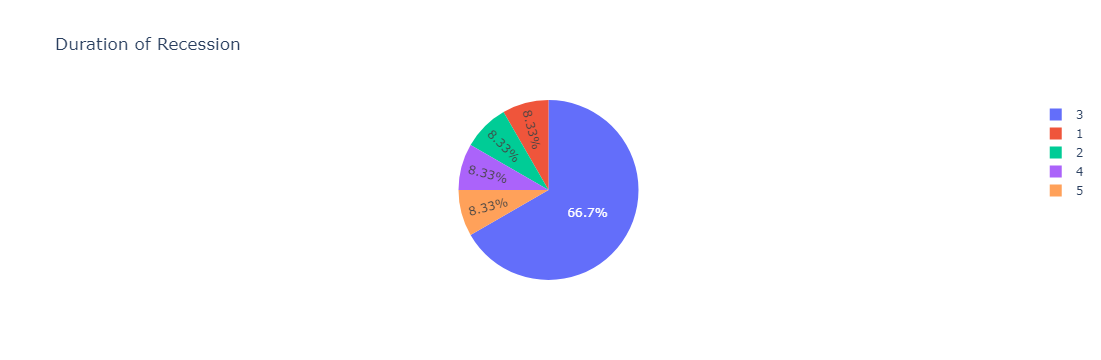

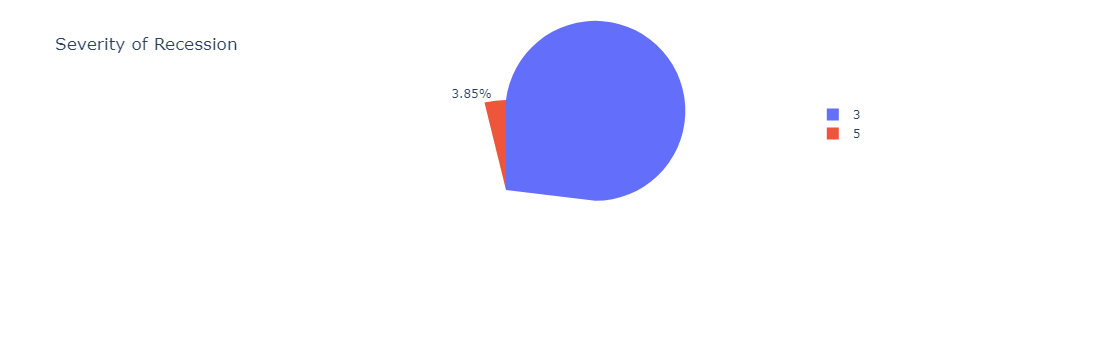

In [36]:
import plotly.graph_objects as go

# Assuming you have already defined quarterly_data, recession_periods, recession_duration, and recession_severity

# Create a pie chart for recession duration
fig_duration = go.Figure(data=[go.Pie(labels=recession_duration.index, values=recession_duration)])

# Update layout for duration pie chart
fig_duration.update_layout(title='Duration of Recession',
                           showlegend=True)

# Create a pie chart for recession severity
fig_severity = go.Figure(data=[go.Pie(labels=recession_severity.index, values=recession_severity)])

# Update layout for severity pie chart
fig_severity.update_layout(title='Severity of Recession',
                           showlegend=True)

# Display the pie charts
fig_duration.show()
fig_severity.show()


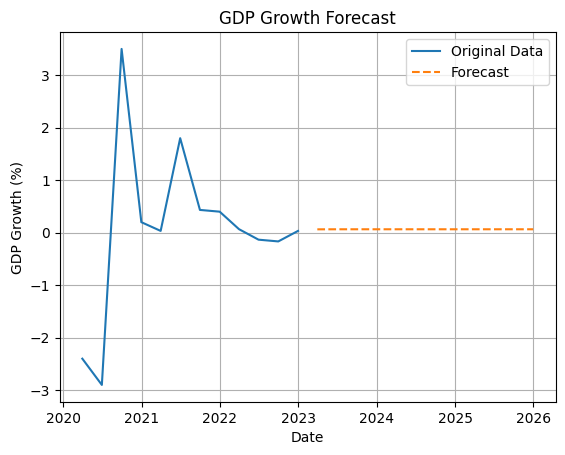

In [37]:
from statsmodels.tsa.arima.model import ARIMA

# Fit ARIMA model
model = ARIMA(quarterly_data['GDP Growth'], order=(1, 1, 1))
result = model.fit()

# Forecast next 12 periods
forecast = result.forecast(steps=12)

# Plot original data and forecast
plt.plot(quarterly_data.index, quarterly_data['GDP Growth'], label='Original Data')
plt.plot(forecast.index, forecast, label='Forecast', linestyle='--')
plt.title('GDP Growth Forecast')
plt.xlabel('Date')
plt.ylabel('GDP Growth (%)')
plt.legend()
plt.grid(True)
plt.show()


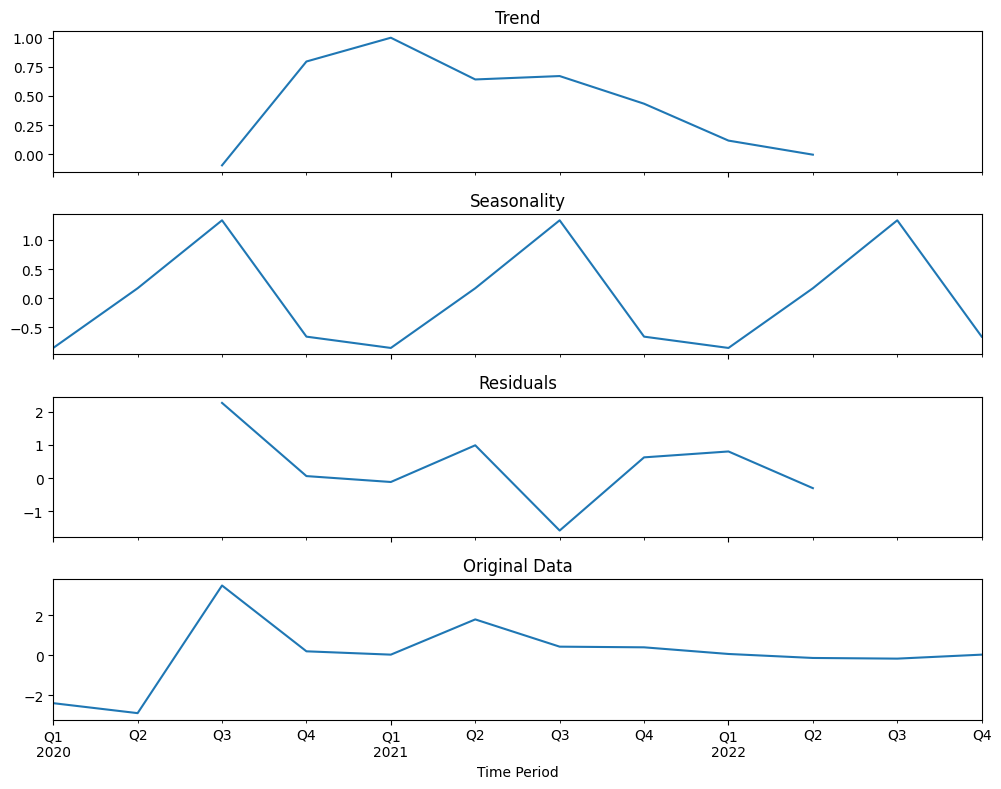

In [38]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Perform seasonal decomposition
decomposition = seasonal_decompose(quarterly_data['GDP Growth'], model='additive')

# Plot the decomposition
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 8), sharex=True)
decomposition.trend.plot(ax=ax1)
ax1.set_title('Trend')
decomposition.seasonal.plot(ax=ax2)
ax2.set_title('Seasonality')
decomposition.resid.plot(ax=ax3)
ax3.set_title('Residuals')
quarterly_data['GDP Growth'].plot(ax=ax4)
ax4.set_title('Original Data')
plt.tight_layout()
plt.show()


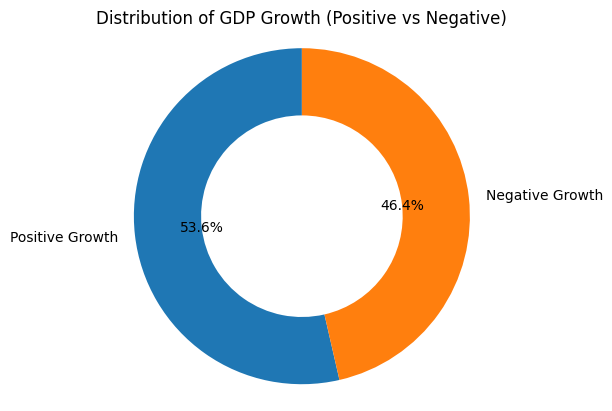

In [39]:
# Calculate the sum of positive and negative GDP growth
positive_growth = quarterly_data[quarterly_data['GDP Growth'] > 0]['GDP Growth'].sum()
negative_growth = quarterly_data[quarterly_data['GDP Growth'] < 0]['GDP Growth'].sum()

# Plot donut chart
fig, ax = plt.subplots()
ax.pie([positive_growth, abs(negative_growth)], labels=['Positive Growth', 'Negative Growth'], autopct='%1.1f%%', startangle=90, wedgeprops=dict(width=0.4))
ax.set_title('Distribution of GDP Growth (Positive vs Negative)')
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()



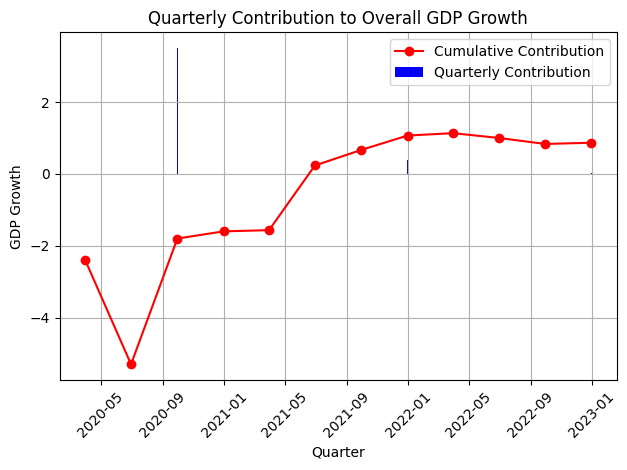

In [40]:
import matplotlib.pyplot as plt

# Calculate the contribution of each quarter's GDP growth to the overall growth
quarterly_contribution = quarterly_data['GDP Growth'].tolist()

# Calculate cumulative sum for the waterfall chart
cumulative_contribution = [sum(quarterly_contribution[:i+1]) for i in range(len(quarterly_contribution))]

# Plot waterfall chart
plt.bar(quarterly_data.index, quarterly_contribution, color='blue', label='Quarterly Contribution')
plt.plot(quarterly_data.index, cumulative_contribution, color='red', marker='o', label='Cumulative Contribution')
plt.title('Quarterly Contribution to Overall GDP Growth')
plt.xlabel('Quarter')
plt.ylabel('GDP Growth')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


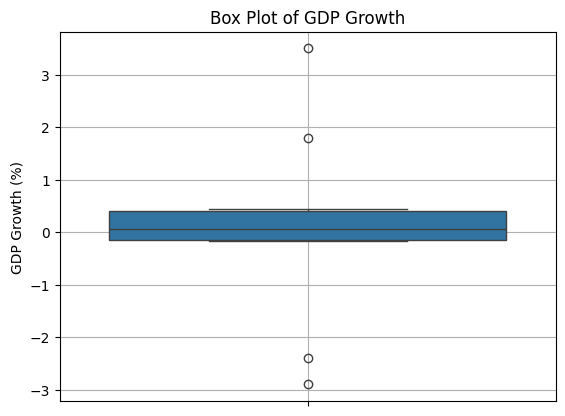

In [41]:
# Plot box plot
sns.boxplot(data=quarterly_data, y='GDP Growth')
plt.title('Box Plot of GDP Growth')
plt.ylabel('GDP Growth (%)')
plt.grid(True)
plt.show()


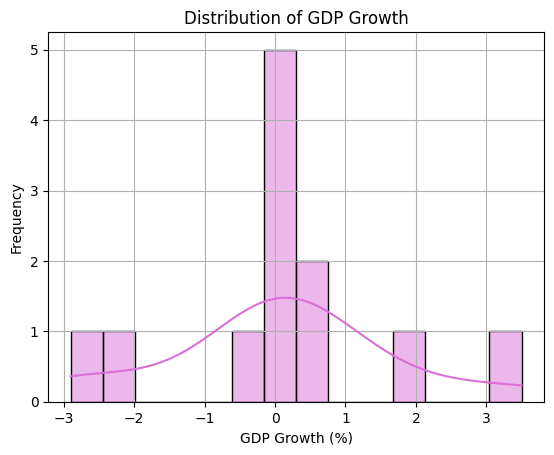

In [44]:
import seaborn as sns

# Plot histogram with KDE
sns.histplot(data=quarterly_data, x='GDP Growth', kde=True,color='orchid')
plt.title('Distribution of GDP Growth')
plt.xlabel('GDP Growth (%)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


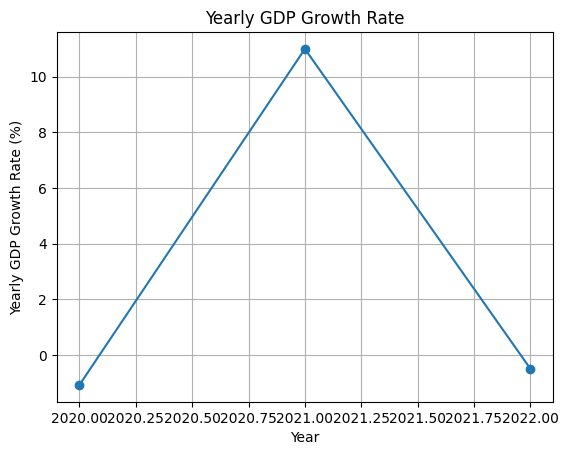

In [45]:
# Compute yearly growth rate
yearly_growth = quarterly_data.groupby(quarterly_data.index.year)['GDP Growth'].last() / \
                quarterly_data.groupby(quarterly_data.index.year)['GDP Growth'].first() - 1

# Plot yearly growth rate
plt.plot(yearly_growth.index, yearly_growth.values, marker='o')
plt.title('Yearly GDP Growth Rate')
plt.xlabel('Year')
plt.ylabel('Yearly GDP Growth Rate (%)')
plt.grid(True)
plt.show()


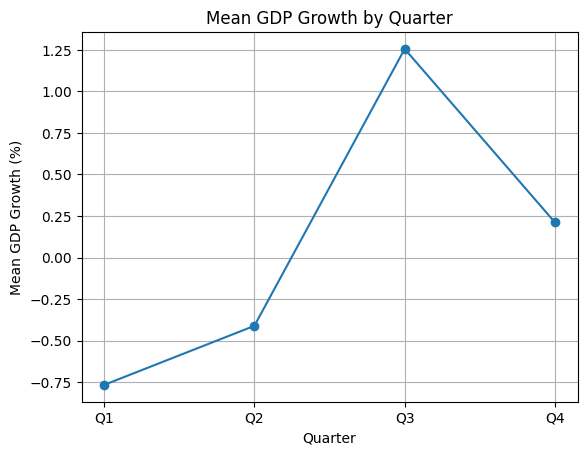

In [49]:
# Compute mean GDP growth for each quarter
quarterly_mean = quarterly_data.groupby(quarterly_data.index.quarter)['GDP Growth'].mean()

# Plot seasonal analysis
plt.plot(quarterly_mean.index, quarterly_mean.values, marker='o')
plt.title('Mean GDP Growth by Quarter')
plt.xlabel('Quarter')
plt.ylabel('Mean GDP Growth (%)')
plt.xticks([1, 2, 3, 4], ['Q1', 'Q2', 'Q3', 'Q4'])
plt.grid(True)
plt.show()


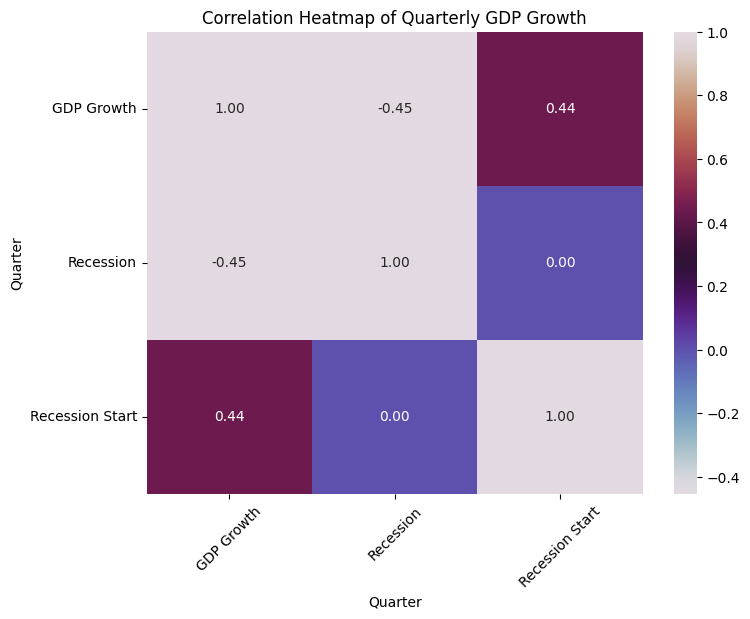

In [51]:
import seaborn as sns

# Calculate the correlation matrix
correlation_matrix = quarterly_data.corr()

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='twilight', fmt=".2f")
plt.title('Correlation Heatmap of Quarterly GDP Growth')
plt.xlabel('Quarter')
plt.ylabel('Quarter')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()
